In this notebook we show the usage of the package `ApApproximation.jl`, based on the results exposed in the paper _Almost-periodic interpolation and approximation_ by J.-P. Gauthier and D. Prandi.

In [1]:
push!(LOAD_PATH, "/Users/darioprandi/Dropbox/Matematica/Projects/Neuro-Geometria/AP_interpolation/julia/ApApproximation.jl/src/");

using Images, TestImages, ImageMagick
using ApApproximation

We will use the following image for the tests.

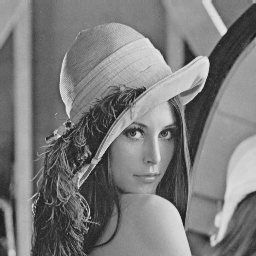

In [2]:
img = testimage("lena_gray_256") |> x->convert(Array{Float64,2}, data(x))
convert(Image, img)

# Almost-periodic interpolation

## Sets of spatial and frequency samples

Fix $Q,N\in\mathbb N$. 

In [3]:
Q, N = 20, 15

(20,15)

By Corollary 2, the first step is to define the sets of spatial samples $E$ and frequencies $F$, which will be invariant under rotations of $2\pi/N$ and have the same number of elements. Namely, in the notation of the paper,

$$
E = \{ R_{\frac{2\pi m}M}\varrho_k \mid \{\varrho_k\}_{k=0}^{Q-1}\subset\mathcal S_N,\,m=0,\ldots,N-1\}, \quad
F = \{ R_{\frac{2\pi m}M}\Lambda_k \mid \{\Lambda_k\}_{k=0}^{Q-1}\subset\mathcal S_N,\,m=0,\ldots,N-1\}
$$

The frequencies $\Lambda$ are dealt internally via the `Frequency` type. This type essentially stores a triple $(\lambda,n,\omega)$ such that 
$$
    \Lambda = \lambda e^{i\left(\omega + \frac{2\pi}N n \right)}, \qquad \lambda>0, \, n\in\{0,\ldots,N-1\},\, \omega\in [0,2\pi/N).
$$
The same is true for the spatial samples $\varrho$. Obviously, $n=0$ for the elements of $\{\Lambda_k\}_{k=0}^{Q-1}$ and $\{\varrho_k\}_{k=0}^{Q-1}$.

A convenient way to define the subsets $\{\varrho_k\}_{k=0}^{Q-1}$ and $\{\Lambda_k\}_{k=0}^{Q-1}$ of $\mathcal S_N$ is through a vector of tuples $\{(n_i,R_i)\}_i$, where:

- $R_i\subset \mathbb R_+$ are discrete sets;
- $n_i\in \mathbb N$.

Then,

$$
    \{\Lambda_k\}_{k=0}^{Q-1} = \bigcup_i \left\{ \lambda\exp\left( \frac{2\pi}N \frac{m}{n_i} \right) \mid \lambda\in R_i, m=0,\ldots, n_i-1 \right\},
$$
and similarly for $\{\varrho_k\}_{k=0}^{Q-1}$. In particular $\sum_i n_i\#(R_i) = Q$.

In [4]:
def = Q/2

v = [  (1, 1:1.:def/2),
    (3, def/2+1:1.:def)
    ];

Qv = sum([v[i][1]*length(v[i][2]) for i in 1:length(v)])

println("Does v agree with Q? $(Qv == Q)")

Does v agree with Q? true


In [5]:
E = BispectralSet(N, v);

println("Size of the set E: (Q,N) = $(size(E))")

Size of the set E: (Q,N) = (20,15)


The following function will plot the corresponding frequencies.

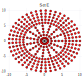

In [7]:
using Plots
gadfly()

function Plots.plot{T<:Real, N}(E::BispectralSet{N,T})
    x, y = cart(E)

    x_max, y_max = maximum(x), maximum(y)
    ρ_max = maximum([x.λ for x in E])

    # Plot the set E
    p = scatter(x, y, marker = (:red, 4), 
            legend = false, 
            size = (315,300), 
            title = "Set E")
    
    # Plot the lines dividing the slices
    for ang in 0:2pi/N:2pi*(1-1/N)
        plot!(t-> cos(ang)*t, t-> sin(ang)*t, 0:.1:ρ_max, line = (:black, :dot))
    end
    p
end

plot(E)

Clearly, with so few points ($20\times 15 = 300$ vs the resolution of the image that is $256\times256 = 65\,536$) the approximation is quite bad.

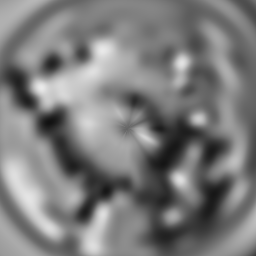

In [8]:
# approximation of the set E
f = cartesian2bispectral(img, E); 

# interpolation on a cartesian grid
img2 = pol2cart(bispectral2pol(f), 256, 256, clip=false)' 

convert(Image, img2)

Defining a bigger frequency set ($Q = 340$, $N=64$, so that $Q\times N = 21\,760$) however, allows for a good interpolation.

Does v agree with Q? true


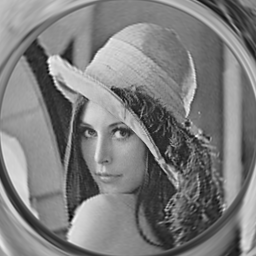

In [9]:
Q, N = 340, 64

max_ϱ = Q/4
step_ϱ = 1.

v = [ (4, 1:step_ϱ:max_ϱ) ];

Qv = sum([v[i][1]*length(v[i][2]) for i in 1:length(v)])

println("Does v agree with Q? $(Qv == Q)")

E = BispectralSet(N, v);

# approximation of the set E
f = cartesian2bispectral(img, E); 

# interpolation on a cartesian grid
img2 = pol2cart(bispectral2pol(f), 256, 256, clip=false)' |> x -> clamp(x,0,1)

convert(Image, img2)

## Almost periodic interpolation

We start by considering the AP interpolation problem. For simplicity, we choose the set of frequencies $F = E$.

We then compute the the matrix operator $\mathcal J:\mathbb C^{Q}\otimes \mathbb C^N \to \mathbb C^{Q}\otimes \mathbb C^N$:
$$
	\mathcal J = \bigoplus_{n=0}^{N-1} \mathcal J_n ,
	\qquad
	(\mathcal J_n)_{j,k} = J_n^{\alpha_j-\omega_k}(\lambda_k\rho_j) \quad \text{for } 0\le j\le Q-1,\, 0\le k\le Q-1.
$$

In [113]:
# @time J = BesselMatrix(E, F);
@time J = BesselMatrix(E);
size(J.matrix)

  2.811145 seconds (14.39 M allocations: 810.015 MB, 12.66% gc time)


(64,340,340)

Finally, the AP interpolation of the test image is obtained as follows.

In [114]:
@time af = ap(f, J);

  1.217709 seconds (45.90 k allocations: 231.520 MB, 9.11% gc time)


To check its correctedness, let us invert it and plot the result.

  0.210966 seconds (45.39 k allocations: 118.450 MB, 10.28% gc time)
Maximal and minimum values of the resulting image: (-0.014753984535499764,1.0068751116275774)


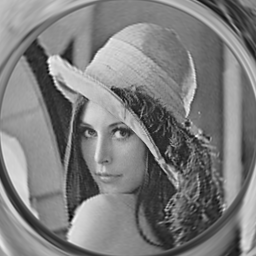

In [115]:
@time f2 = iap(af, J);

img2 = pol2cart(bispectral2pol(f2), 256, 256, clip=false)'  
println("Maximal and minimum values of the resulting image: $(extrema(img2))")

convert(Image, clamp(img2,0,1))

Although this yield a good result when interpolated on the set $E$, the almost periodic function hereby obtained has very huge values outside of this set. This is evident when applying the effect of a translation on the frequencies `af`.

  0.263665 seconds (524.13 k allocations: 131.069 MB, 7.17% gc time)
Maximal and minimum values of the resulting image: (-2.0718921136398325e6,1.985558696505998e6)


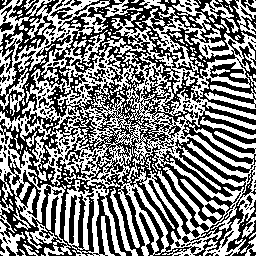

In [116]:
# Translation (in polar coordinates)
ρ = 50.
θ = pi/5
@time f2 = translate(af, ρ, θ) |> x -> iap(x, J);

img2 = pol2cart(bispectral2pol(f2), 256, 256, clip=false)' 

println("Maximal and minimum values of the resulting image: $(extrema(img2))")
convert(Image, clamp(img2,0,1))

## Almost periodic approximation

To solve the above problem, the solution proposed in the paper is to look for an AP approximation of the starting image. That is, one considers a set of frequencies $F$ of size $P\times N$, where $P<Q$, and looks for the AP function having frequencies in $F$ which better approximates the image on the set $E$. 

In [ ]:
P, M = Q, N

max_λ = 2. 
step_λ = max_λ / (Q/4)

v = [ (4, step_λ:step_λ:max_λ) ];

Pv = sum([v[i][1]*length(v[i][2]) for i in 1:length(v)])
println("Does v agree with P? $(Pv == P)")

F = BispectralSet(N, v);

We have also the possibility of fixing weights on the frequencies of $F$. In this example, we want the image to be concentrated on low frequencies.

Generating Bessel matrices: 
  4.134228 seconds (19.38 M allocations: 1.215 GB, 13.04% gc time)
AP approximation: 
  2.133575 seconds (46.54 k allocations: 514.100 MB, 3.96% gc time)
Inverse AP approximation: 
  0.179611 seconds (45.39 k allocations: 118.450 MB, 13.37% gc time)


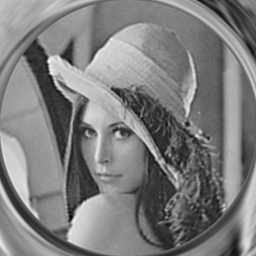

In [118]:
quarter = round(Int,size(F,1)/4)
d = [   .1*ones(quarter); 
        .1*ones(quarter); 
        1.*ones(quarter); 
        1e2*ones(size(F,1) - 3*quarter); ]
d *= 100

println("Generating Bessel matrices: ")
@time J = BesselMatrix(E,F, weights = d);
println("AP approximation: ")
@time af = ap(f, F, J)
println("Inverse AP approximation: ")
@time f2 = iap(af, E, J)

img2 = pol2cart(bispectral2pol(f2), 256, 256, clip = false)'
convert(Image, clamp(img2,0,1))

The same translation test as before, now yields a correct result.

  0.267989 seconds (524.13 k allocations: 131.069 MB, 9.47% gc time)
Maximal and minimum values of the resulting image: (-3.0363215803325594,0.960815019280367)


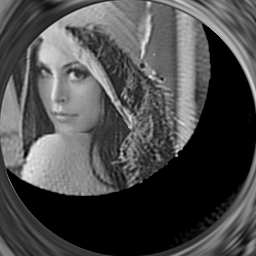

In [120]:
ρ = 50.
θ = pi/5
@time f_trans = translate(af, ρ, θ) |> x -> iap(x, E, J)

img2 = pol2cart(bispectral2pol(f_trans), 256, 256, clip = false)'

println("Maximal and minimum values of the resulting image: $(extrema(img2))")
convert(Image, clamp(img2,0,1))